In [11]:
import scanpy as sc
import matplotlib.pyplot as plt
import os
import pandas as pd
os.chdir("/Users/piamozdzanowski/Documents/GitHub/PerturbCycleVI")

In [12]:
adata = sc.read_h5ad('cluster_files/adata_HT29_Dapagliflozin_balanced.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 8596 × 19887
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'drugconc', 'n_genes'
    var: 'n_cells'
    layers: 'counts'


In [13]:
print(adata.obs["drugconc"].unique())
ordered_conc = [0,0.05,0.5,5]
adata.obs["drugconc_ordered"] = pd.Categorical(
    adata.obs["drugconc"],
    categories=ordered_conc,
    ordered=True
)
print("Sorted Drug concentrations",adata.obs["drugconc_ordered"].unique())

[0.   0.05 0.5  5.  ]
Sorted Drug concentrations [0.00, 0.05, 0.50, 5.00]
Categories (4, float64): [0.00 < 0.05 < 0.50 < 5.00]


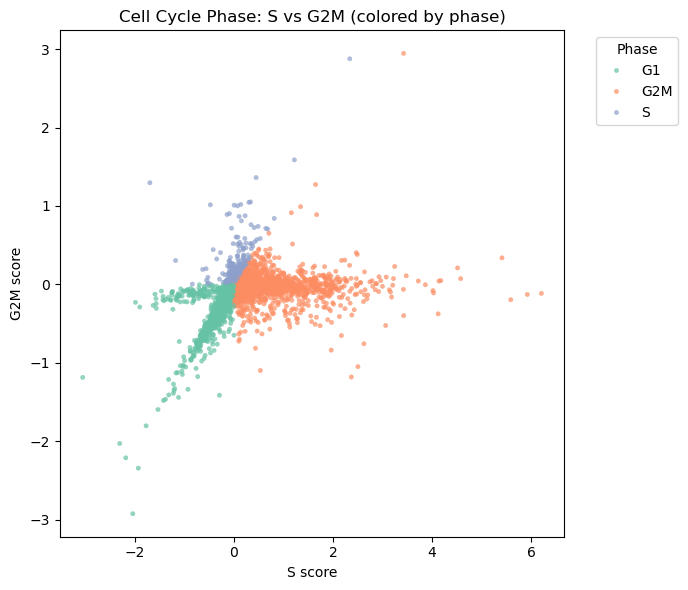

In [14]:
import seaborn as sns
# Plot with seaborn
plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=adata.obs,
    x="G2M_score",
    y="S_score",
    hue="phase",
    palette="Set2",
    s=10,
    alpha=0.7,
    edgecolor=None
)
plt.xlabel("S score")
plt.ylabel("G2M score")
plt.title("Cell Cycle Phase: S vs G2M (colored by phase)")
plt.legend(title="Phase", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

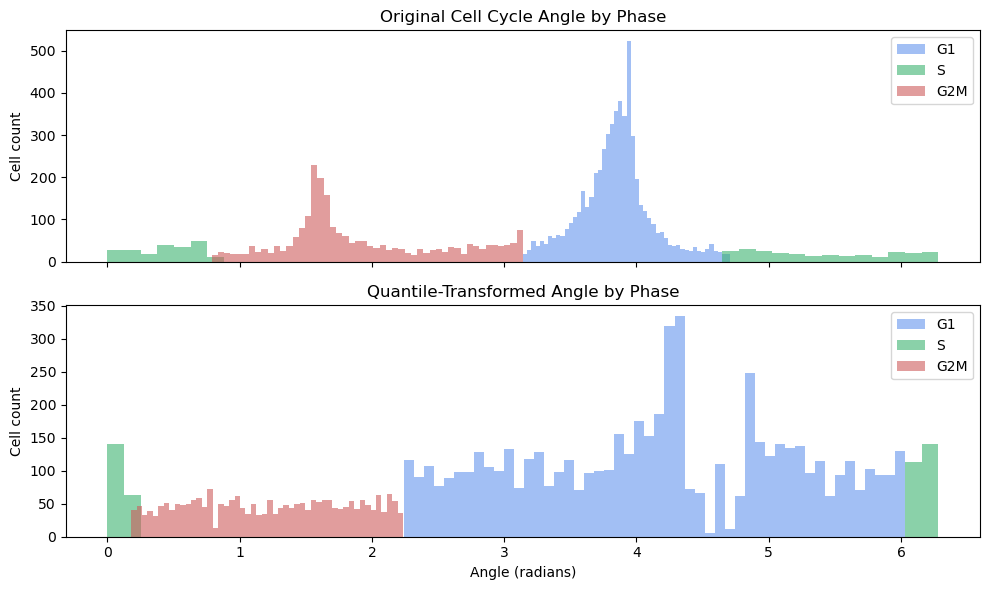

In [15]:
from sklearn.preprocessing import QuantileTransformer
import numpy as np
import matplotlib.pyplot as plt

# Compute angle from S and G2M scores
s_score = adata.obs["S_score"].values
g2m_score = adata.obs["G2M_score"].values
angle = np.mod(np.arctan2(g2m_score, s_score), 2 * np.pi)

# Quantile transform based on drugconc == 0
control_mask = adata.obs["drugconc"] == 0.0
angle_control = angle[control_mask].reshape(-1, 1)

qt = QuantileTransformer(output_distribution='uniform', random_state=0)
qt.fit(angle_control)

angle_qt_all = qt.transform(angle.reshape(-1, 1)).flatten() * 2 * np.pi
adata.obs["G2M_S_angle"] = angle_qt_all

# Prepare phase-based histograms
phases = adata.obs["phase"]
phase_labels = ["G1", "S", "G2M"]
colors = {"G1": "cornflowerblue", "S": "mediumseagreen", "G2M": "indianred"}

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Original angle
for phase in phase_labels:
    subset = angle[phases == phase]
    axs[0].hist(subset, bins=50, alpha=0.6, label=phase, color=colors[phase])
axs[0].set_title("Original Cell Cycle Angle by Phase")
axs[0].set_ylabel("Cell count")
axs[0].legend()

# Quantile-transformed angle
for phase in phase_labels:
    subset_qt = angle_qt_all[phases == phase]
    axs[1].hist(subset_qt, bins=50, alpha=0.6, label=phase, color=colors[phase])
axs[1].set_title("Quantile-Transformed Angle by Phase")
axs[1].set_xlabel("Angle (radians)")
axs[1].set_ylabel("Cell count")
axs[1].legend()

plt.tight_layout()
plt.show()

In [16]:
adata.write("cluster_files/adata_HT29_Dapagliflozin_balanced_qtn_angle.h5ad")

In [17]:
# Preprocessing
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=10000, subset=True)
#sc.pp.scale(adata, max_value=10)

In [8]:
# PCA and neighbors
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)

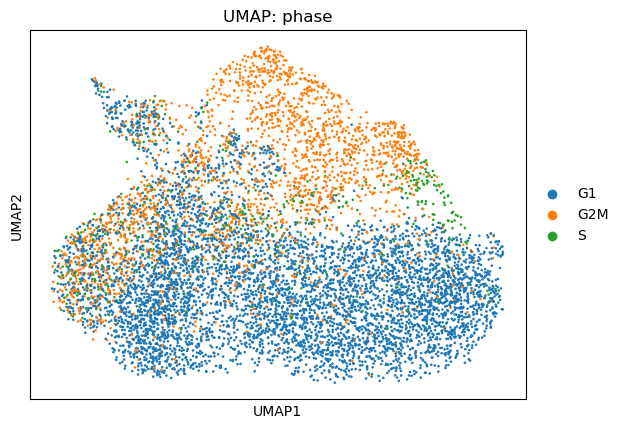

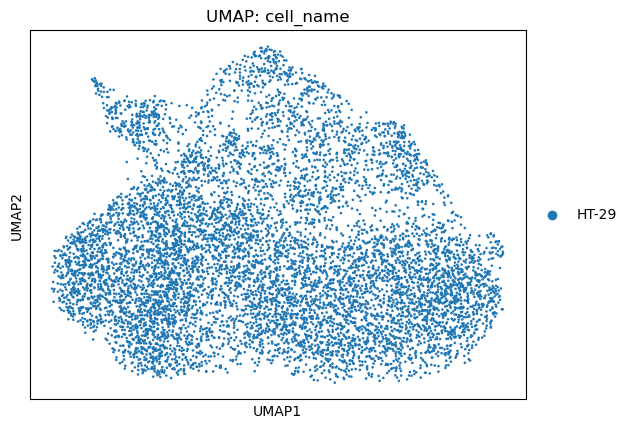

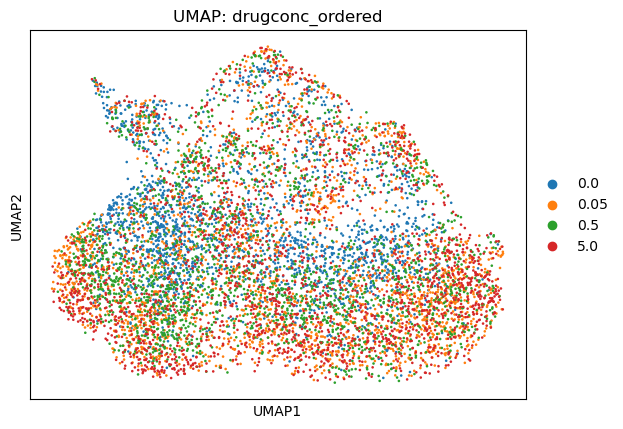

In [9]:
# UMAP plots
sc.pl.umap(adata, color=["phase"], title="UMAP: phase")
sc.pl.umap(adata, color=["cell_name"], title="UMAP: cell_name")
sc.pl.umap(adata, color=["drugconc_ordered"], title="UMAP: drugconc_ordered")


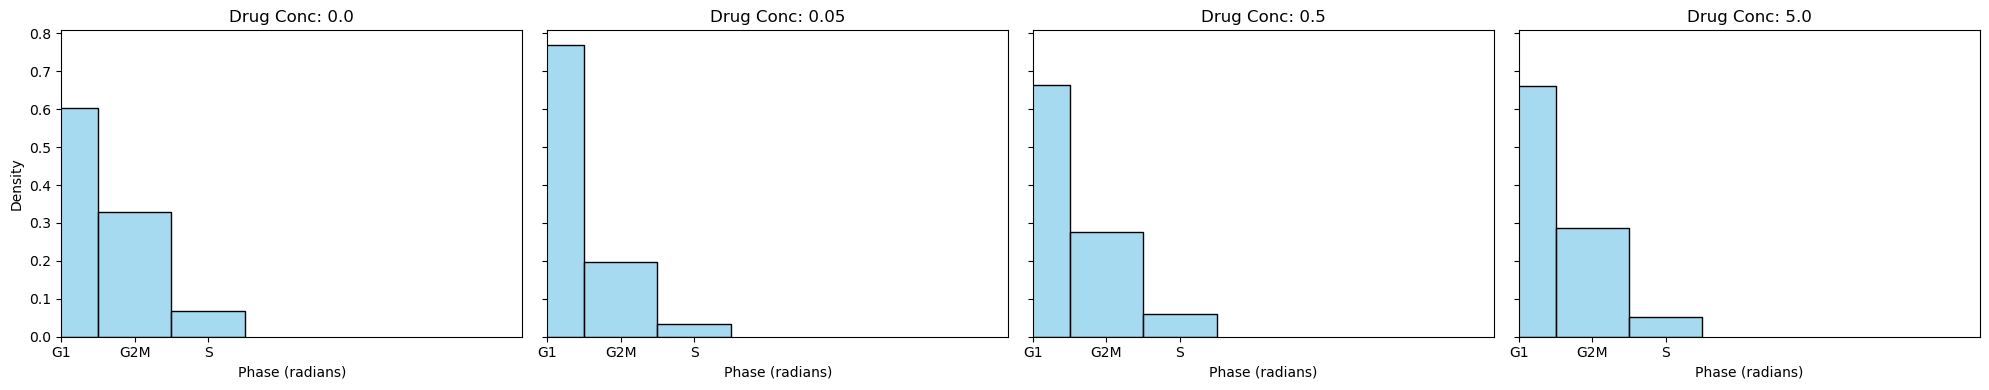

In [10]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Ensure "phase" and "drugconc_ordered" exist
assert "phase" in adata.obs and "drugconc_ordered" in adata.obs

unique_concs = sorted(adata.obs["drugconc_ordered"].unique())
n = len(unique_concs)

# Set up subplots
fig, axes = plt.subplots(1, n, figsize=(5 * n, 4), sharey=True)

for i, conc in enumerate(unique_concs):
    subset = adata.obs[adata.obs["drugconc_ordered"] == conc]
    sns.histplot(subset["phase"], bins=50, stat="density", ax=axes[i], color="skyblue")
    axes[i].set_title(f"Drug Conc: {conc}")
    axes[i].set_xlabel("Phase (radians)")
    axes[i].set_xlim(0, 2 * np.pi)

axes[0].set_ylabel("Density")
plt.tight_layout()
plt.show()


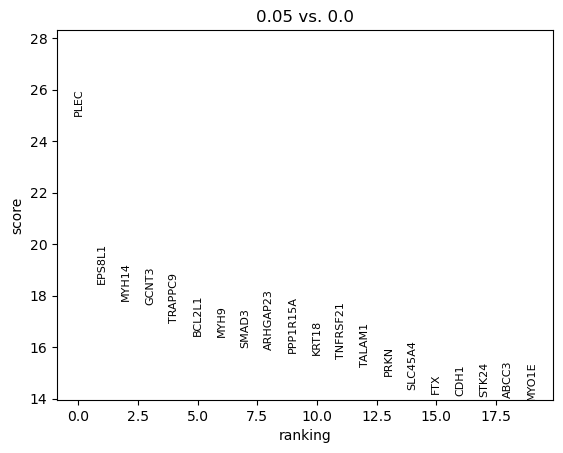

,names,scores,logfoldchanges,pvals,pvals_adj
0,PLEC,24.995621,2.161690,3.270112e-128,1.635056e-124
1,EPS8L1,18.460873,1.970089,6.351036e-73,1.587759e-69
2,MYH14,17.789589,1.278417,2.289916e-68,4.579831e-65
3,GCNT3,17.662834,1.444695,1.946686e-67,3.244477e-64
4,TRAPPC9,16.947447,1.225369,2.102359e-62,3.003371e-59
5,BCL2L1,16.460407,1.463183,4.835460e-59,6.044326e-56
6,MYH9,16.407925,1.235713,9.927529e-59,1.103059e-55
7,SMAD3,15.981099,1.138231,6.906792e-56,6.906792e-53
8,ARHGAP23,15.884688,1.582644,3.742736e-55,3.402488e-52
9,PPP1R15A,15.780266,1.276856,1.424347e-54,1.186956e-51


In [15]:
sc.tl.rank_genes_groups(
    adata,
    groupby="drugconc_ordered",
    groups=[0.05],         # test group
    reference=0.0,         # control group
    method="t-test",         # or "wilcoxon"
    use_raw=False            # depends on your setup, probably False here
)

sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

# Or extract the result as a DataFrame
de_df = sc.get.rank_genes_groups_df(adata, group="0.05")
de_df.head(50)

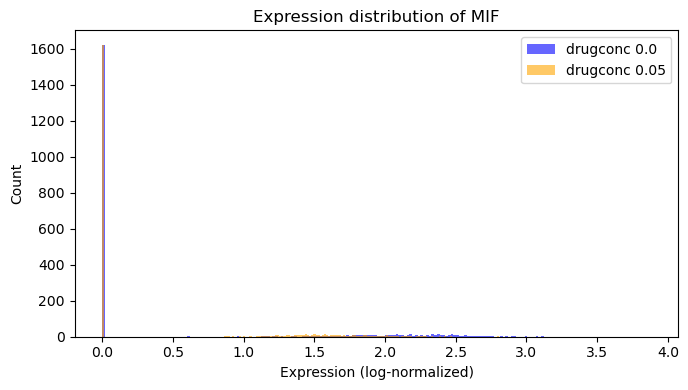

In [23]:
import matplotlib.pyplot as plt
import numpy as np

gene = "MIF"
groups = [0.0, 0.05]
colors = ['blue', 'orange']

# Extract expression values
expr = adata[:, gene].X.toarray().flatten() if hasattr(adata[:, gene].X, "toarray") else adata[:, gene].X
df = adata.obs.copy()
df[gene] = expr

# Plot histograms
plt.figure(figsize=(7, 4))
for i, g in enumerate(groups):
    subset = df[df["drugconc_ordered"] == g][gene]
    plt.hist(subset, bins=200, alpha=0.6, label=f"drugconc {g}", color=colors[i], density=False)

plt.title(f"Expression distribution of {gene}")
plt.xlabel("Expression (log-normalized)")
plt.ylabel("Count")  # Changed from "Density"
plt.legend()
plt.tight_layout()
plt.show()


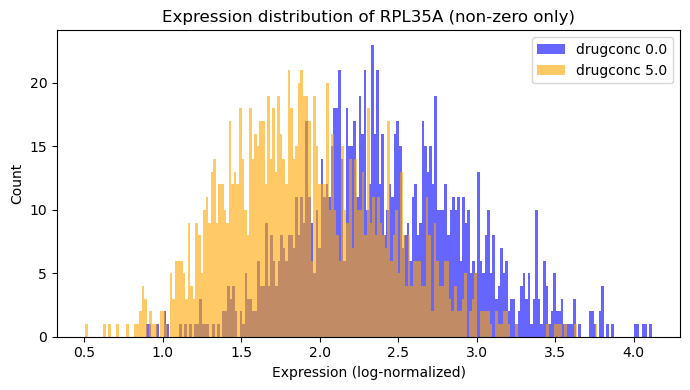

In [30]:
import matplotlib.pyplot as plt
import numpy as np

gene = "RPL35A"
groups = [0.0, 5.00]
colors = ['blue', 'orange']

# Extract expression values
expr = adata[:, gene].X.toarray().flatten() if hasattr(adata[:, gene].X, "toarray") else adata[:, gene].X
df = adata.obs.copy()
df[gene] = expr

# Plot histograms
plt.figure(figsize=(7, 4))
for i, g in enumerate(groups):
    subset = df[df["drugconc_ordered"] == g][gene]
    subset = subset[subset > 0]  # Remove zeros
    plt.hist(subset, bins=200, alpha=0.6, label=f"drugconc {g}", color=colors[i], density=False)

plt.title(f"Expression distribution of {gene} (non-zero only)")
plt.xlabel("Expression (log-normalized)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assumes 'pct_mito' and 'drugconc_ordered' are in adata.obs
plt.figure(figsize=(8, 5))
sns.boxplot(data=adata.obs, x="drugconc_ordered", y="pct_mito", palette="Set2")
plt.xlabel("Drug Concentration")
plt.ylabel("Percent Mitochondrial Genes")
plt.title("Mitochondrial Gene Fraction by Drug Concentration")
plt.tight_layout()
plt.show()


ValueError: Could not interpret value `pct_mito` for `y`. An entry with this name does not appear in `data`.

<Figure size 800x500 with 0 Axes>

In [19]:
# List of genes you're interested in
genes_of_interest = ["MT-RNR1", "RPLP0", "SMAD3", "RPS8"]

# Filter the DE DataFrame for these genes
de_df_filtered = de_df[de_df["names"].isin(genes_of_interest)]

# Show the results
display(de_df_filtered)


,names,scores,logfoldchanges,pvals,pvals_adj
7,SMAD3,15.981099,1.138231,6.906792e-56,6.906792e-53
9982,RPS8,-5.680149,-0.381494,1.437905e-08,2.535989e-07
9999,MT-RNR1,-38.749687,-0.695190,2.412312e-281,2.412312e-277


In [17]:
# Sort DE genes by adjusted p-value (ascending = most significant first)
de_df_sorted = de_df.sort_values("pvals_adj")

# Display top 50
de_df_sorted.head(50)


,names,scores,logfoldchanges,pvals,pvals_adj
9999,MT-RNR1,-38.749687,-0.695190,2.412312e-281,2.412312e-277
0,PLEC,24.995621,2.161690,3.270112e-128,1.635056e-124
9998,MT-RNR2,-24.692429,-0.380473,5.725199e-126,1.908400e-122
1,EPS8L1,18.460873,1.970089,6.351036e-73,1.587759e-69
2,MYH14,17.789589,1.278417,2.289916e-68,4.579831e-65
3,GCNT3,17.662834,1.444695,1.946686e-67,3.244477e-64
4,TRAPPC9,16.947447,1.225369,2.102359e-62,3.003371e-59
5,BCL2L1,16.460407,1.463183,4.835460e-59,6.044326e-56
6,MYH9,16.407925,1.235713,9.927529e-59,1.103059e-55
7,SMAD3,15.981099,1.138231,6.906792e-56,6.906792e-53


Cluster sizes:
 leiden_2
0    5327
1    5285
Name: count, dtype: int64


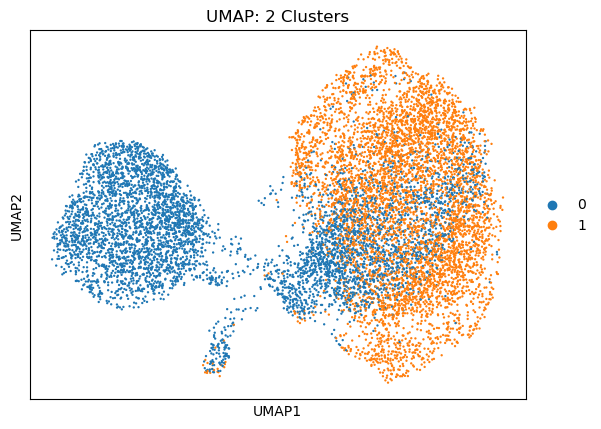

In [23]:
# Compute neighbors and run Leiden clustering with resolution tuned for 2 clusters
sc.pp.neighbors(adata, n_neighbors=15, use_rep="X")  # or use_rep="X_pca" if PCA is available
sc.tl.leiden(adata, resolution=0.3, key_added="leiden_2")

# Confirm number of clusters
print("Cluster sizes:\n", adata.obs["leiden_2"].value_counts())

# Optional: visualize
sc.pl.umap(adata, color="leiden_2", title="UMAP: 2 Clusters")


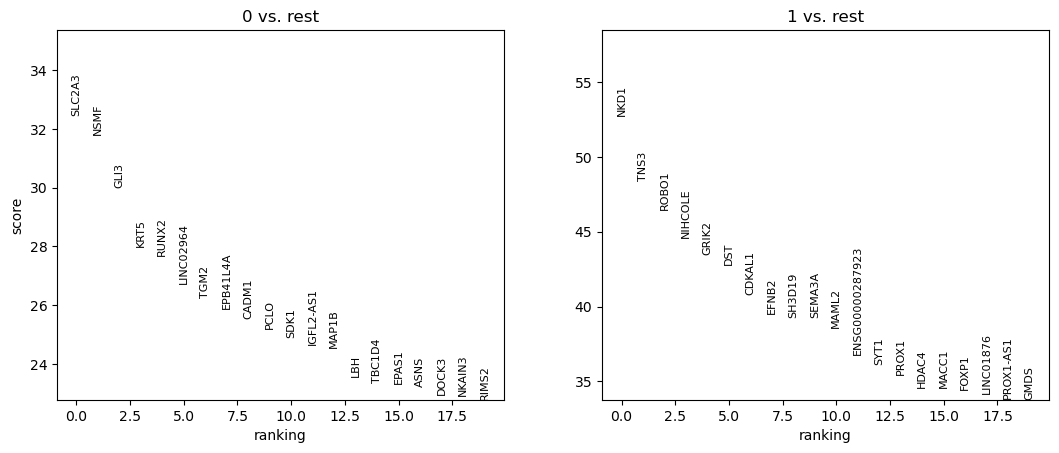

In [24]:
# Perform DE between the two clusters
sc.tl.rank_genes_groups(
    adata,
    groupby="leiden_2",
    method="t-test",
    use_raw=True,
    key_added="rank_genes_leiden2"
)

# Plot top differentially expressed genes
sc.pl.rank_genes_groups(adata, key="rank_genes_leiden2", n_genes=20, sharey=False)

In [ ]:
de_result = sc.get.rank_genes_groups_df(adata, key="rank_genes_leiden2", group='0')
print(de_result.head())

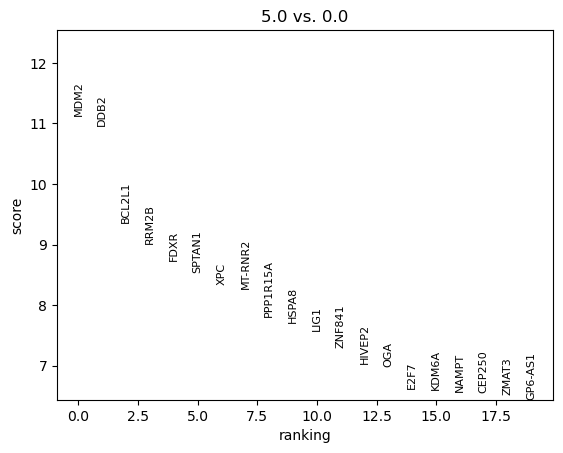

In [32]:
import scanpy as sc
import pandas as pd

# Subset to just drugconc 0 and 5.0
adata_sub = adata[adata.obs["drugconc_ordered"].isin([0.0, 5.0])].copy()

# Convert to categorical with correct order
adata_sub.obs["drugconc_ordered"] = adata_sub.obs["drugconc_ordered"].astype("category")
adata_sub.obs["drugconc_ordered"] = adata_sub.obs["drugconc_ordered"].cat.reorder_categories([0.0, 5.0], ordered=True)

# Run DE test (t-test, fast)
sc.tl.rank_genes_groups(adata_sub, groupby="drugconc_ordered", reference=0.0, method="t-test", use_raw=False)

# Plot top DE genes
sc.pl.rank_genes_groups(adata_sub, n_genes=20, sharey=False)

# Extract DE table
result = adata_sub.uns["rank_genes_groups"]
groups = result["names"].dtype.names
de_df = pd.DataFrame({
    'gene': result["names"][groups[0]],
    'logfc': result["logfoldchanges"][groups[0]],
    'pval': result["pvals"][groups[0]],
    'pval_adj': result["pvals_adj"][groups[0]]
})


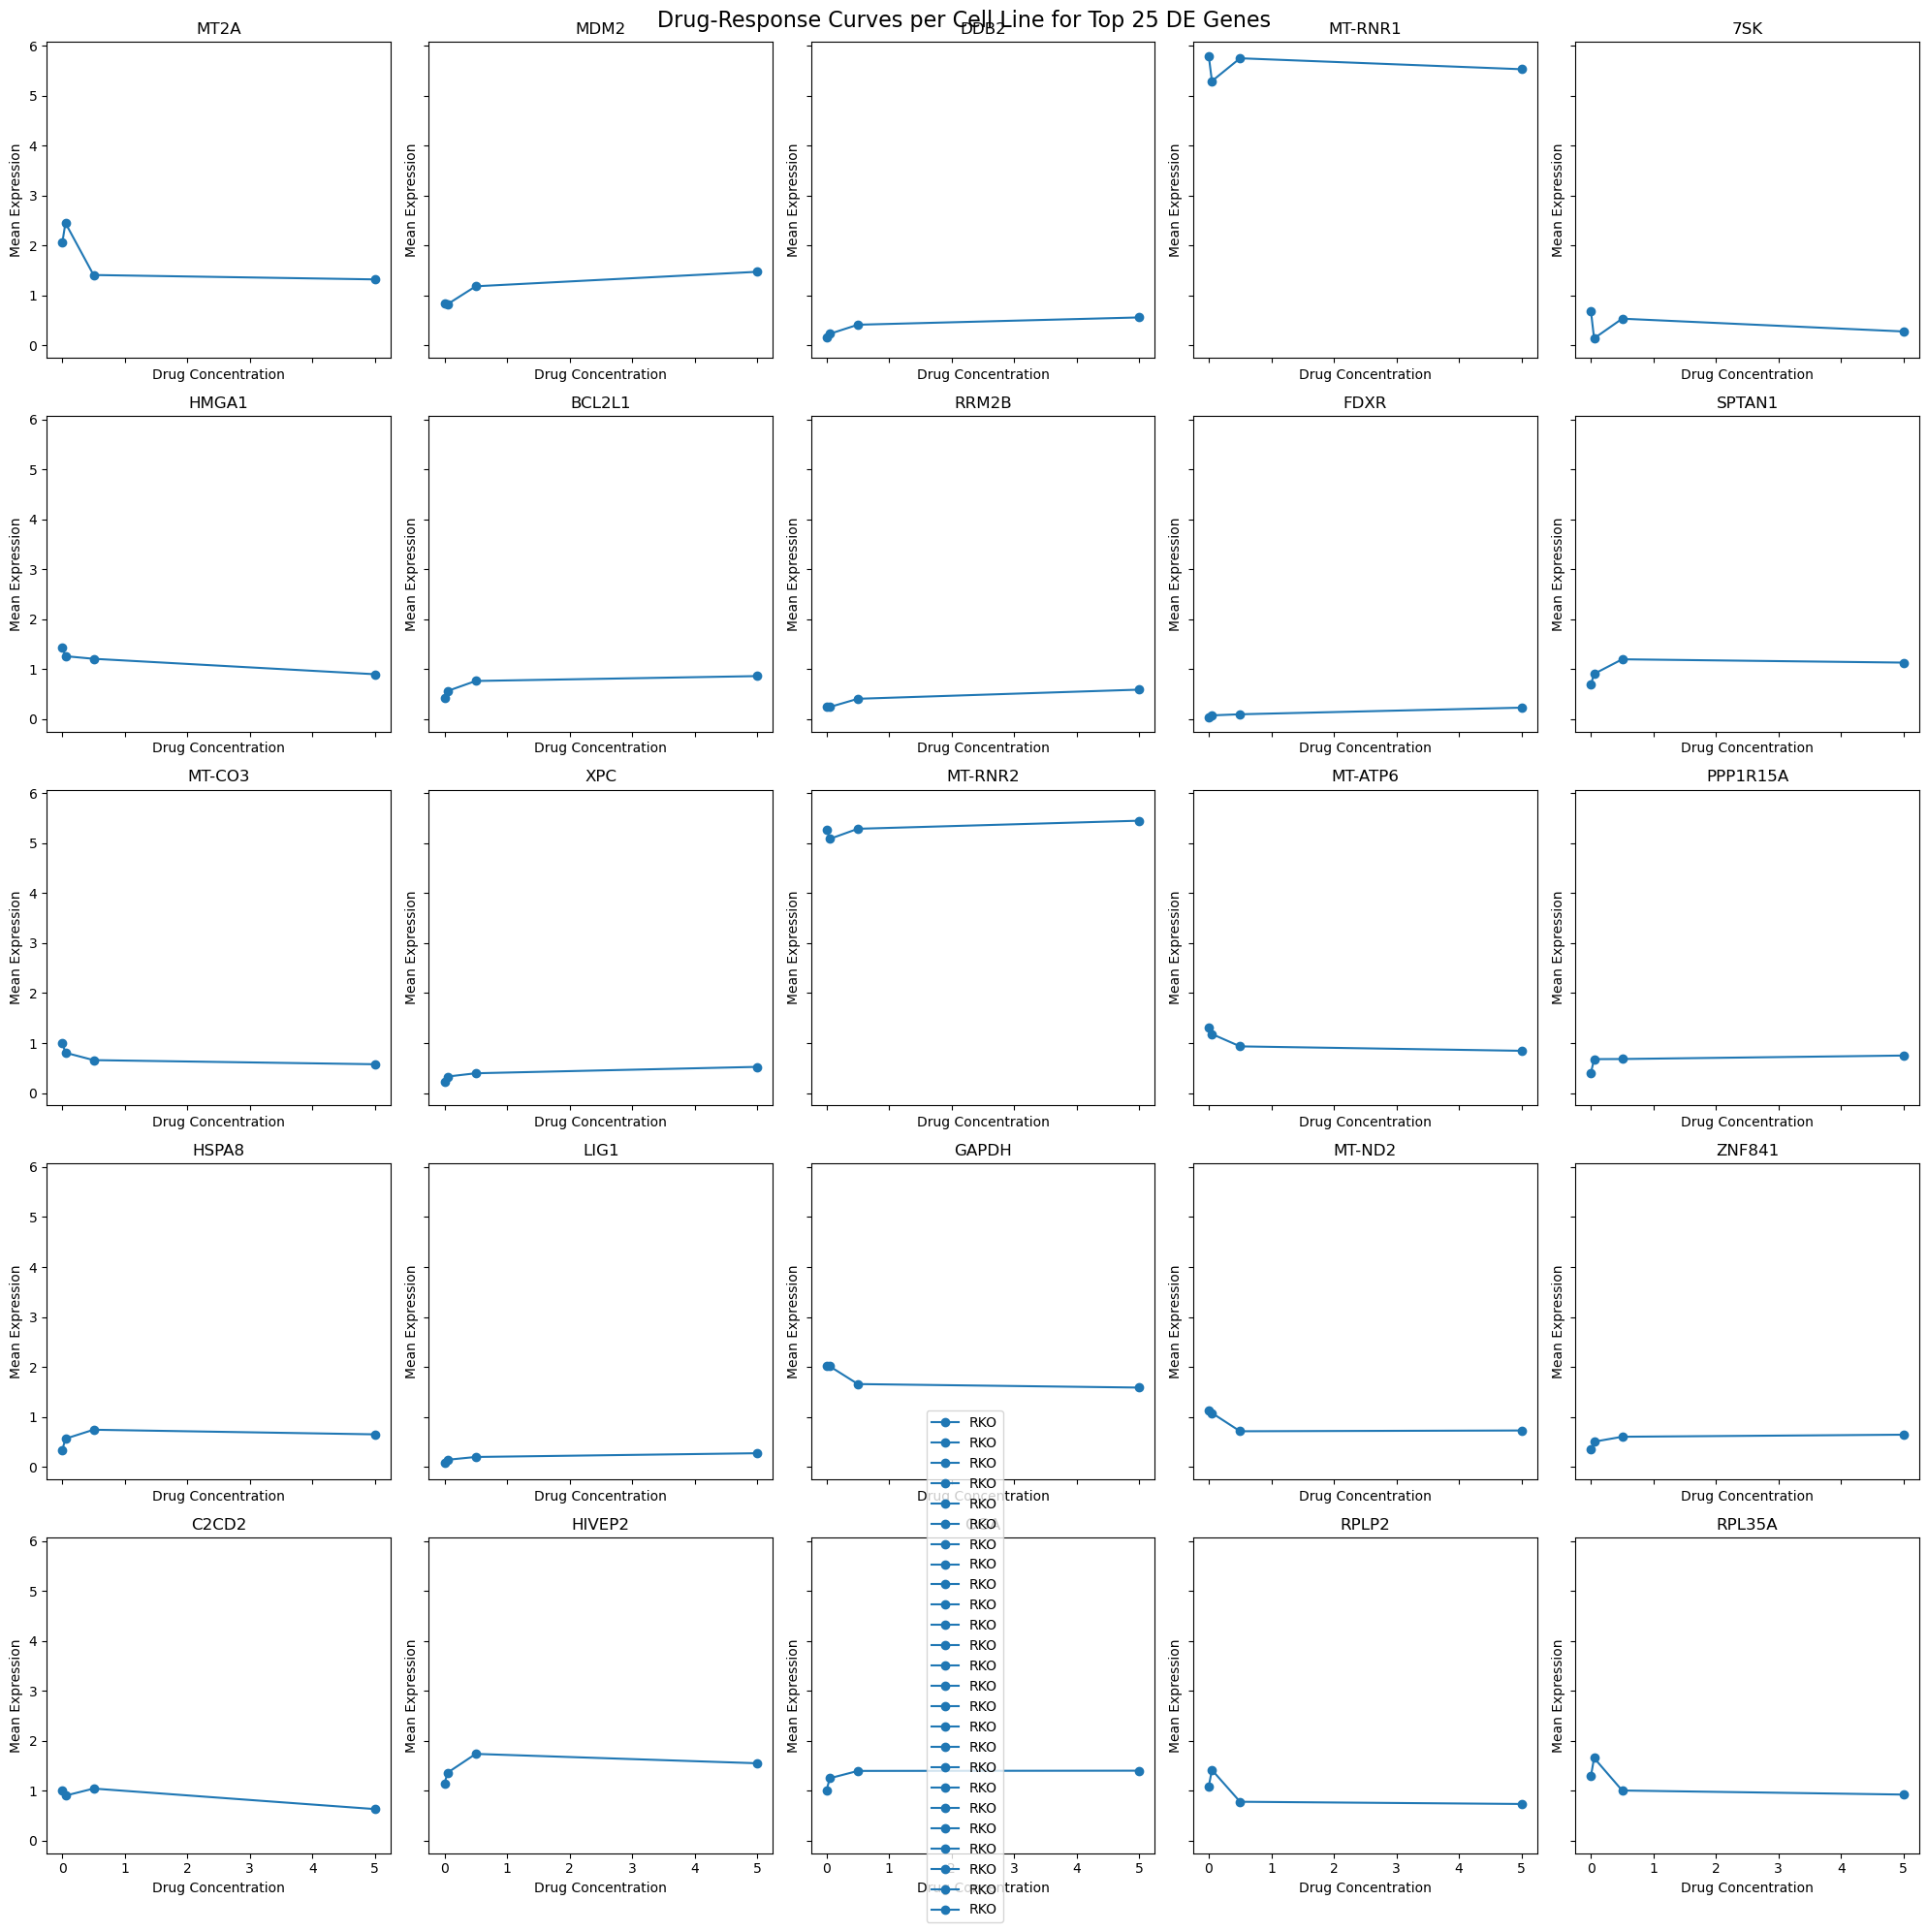

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Get top 25 genes by adjusted p-value
top_genes = de_df.nsmallest(25, 'pval_adj')['gene'].values

concentrations = sorted(adata.obs["drugconc"].unique())
cell_lines = adata.obs["cell_name"].unique()

# Create plot
fig, axs = plt.subplots(5, 5, figsize=(20, 20), sharex=True, sharey=True)

for ax, gene in zip(axs.ravel(), top_genes):
    for cell_line in cell_lines:
        means = []
        for conc in concentrations:
            mask = (adata.obs["drugconc"] == conc) & (adata.obs["cell_name"] == cell_line)
            expr = adata[mask, gene].X
            mean_expr = np.asarray(expr.mean()).item() if expr.shape[0] > 0 else np.nan
            means.append(mean_expr)
        
        ax.plot(concentrations, means, marker='o', label=cell_line)

    ax.set_title(gene)
    ax.set_xlabel("Drug Concentration")
    ax.set_ylabel("Mean Expression")

fig.suptitle("Drug-Response Curves per Cell Line for Top 25 DE Genes", fontsize=16)
fig.tight_layout()
fig.legend(loc='lower center', ncol=len(cell_lines), bbox_to_anchor=(0.5, -0.01))
plt.savefig("drug_response_curves_top25_by_cellline.png", dpi=300, bbox_inches="tight")
plt.show()


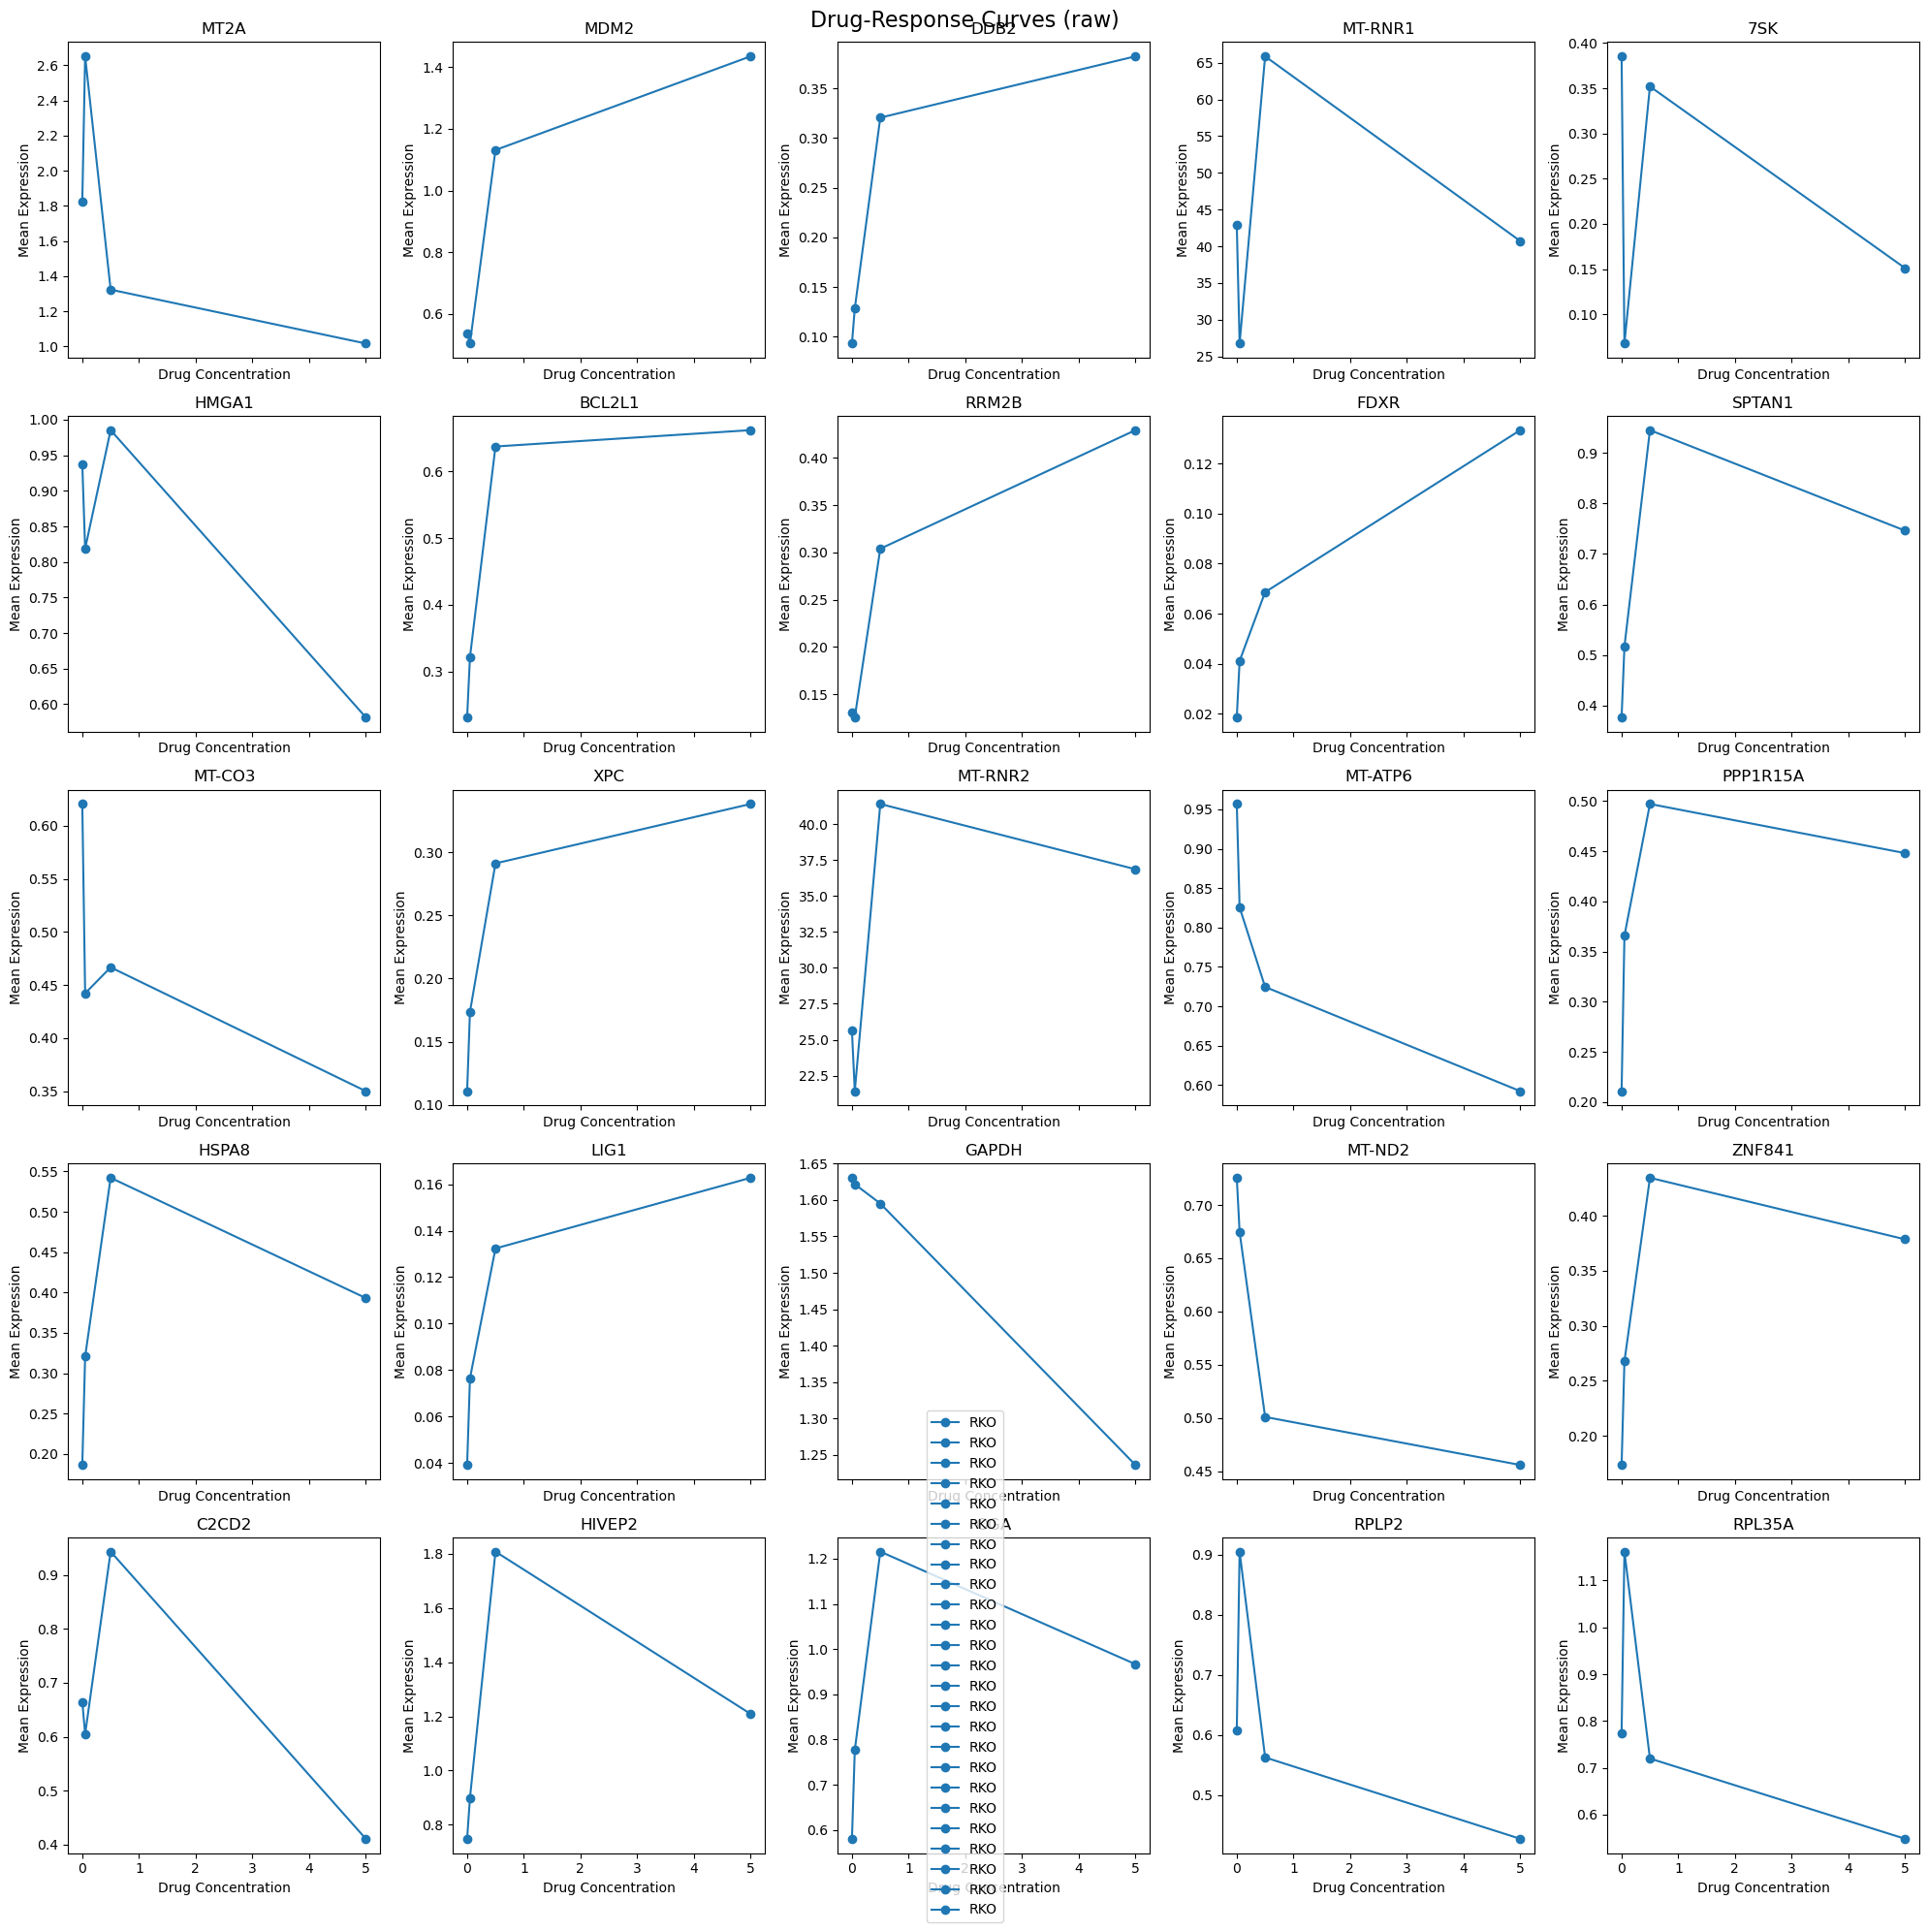

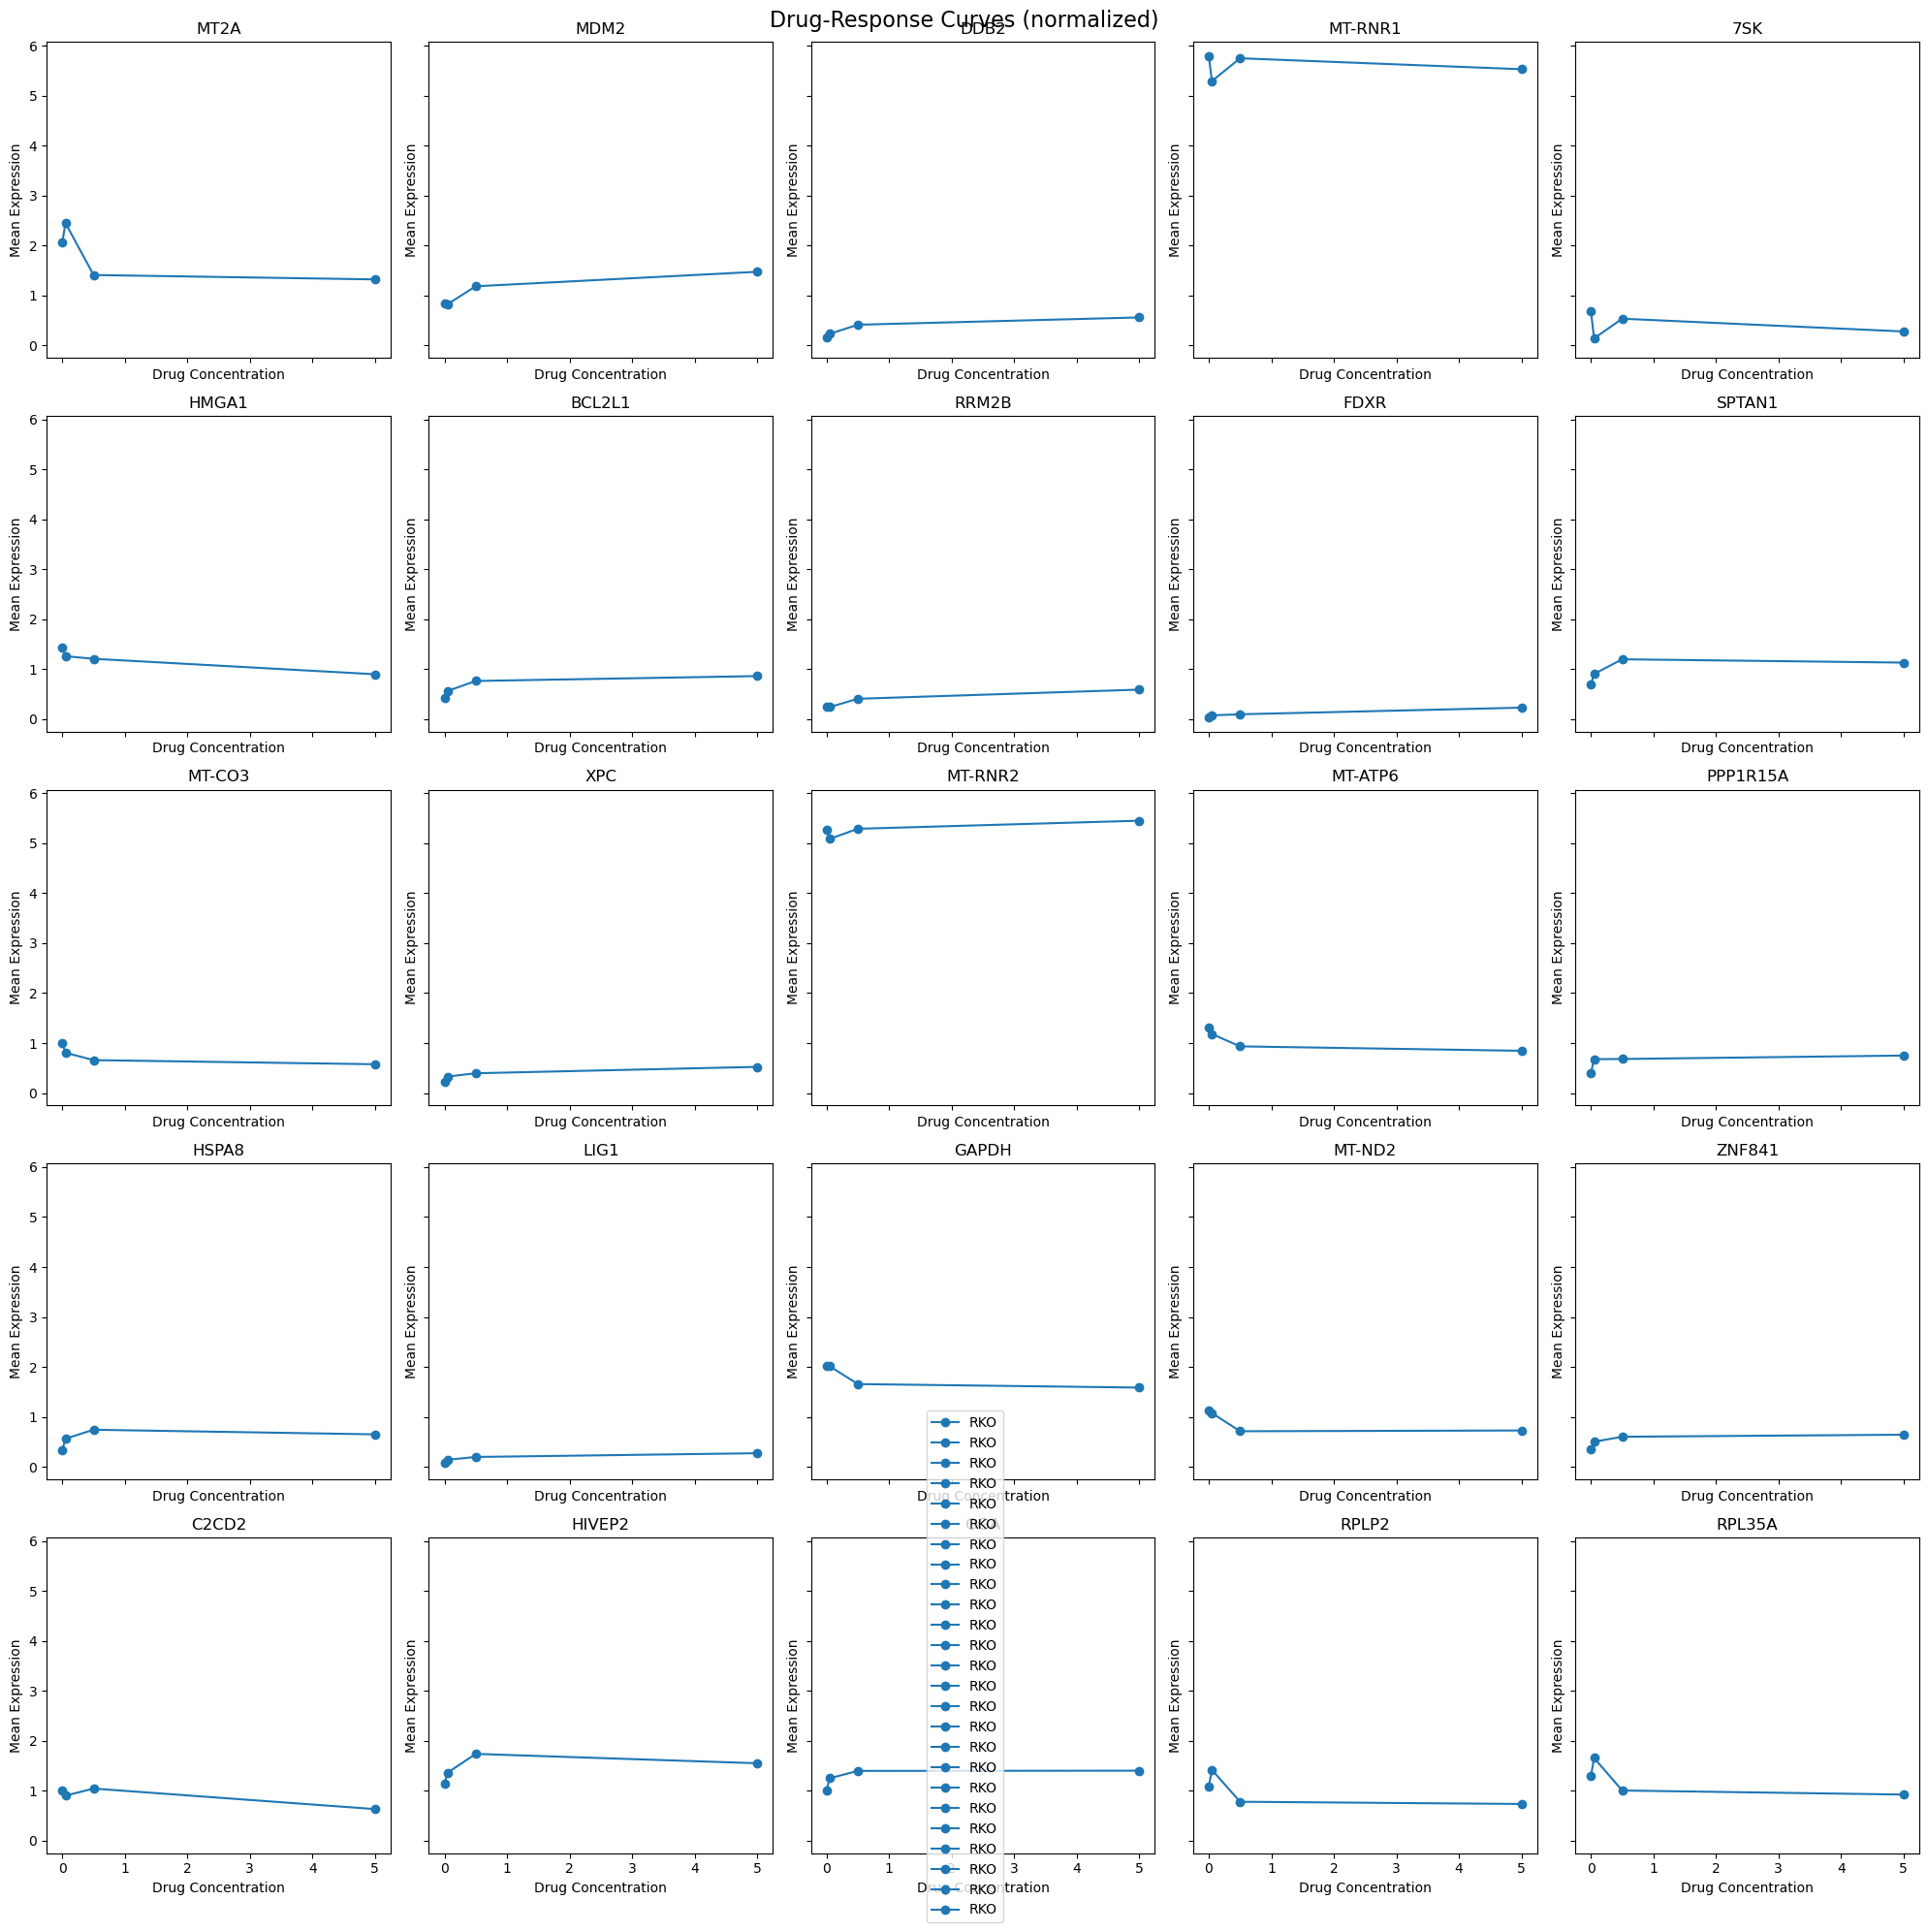

In [36]:
for layer_name, matrix in [("raw", adata.raw.X), ("normalized", adata.X)]:
    share_y = False if layer_name == "raw" else True
    fig, axs = plt.subplots(5, 5, figsize=(20, 20), sharex=True, sharey=share_y)
    
    for ax, gene in zip(axs.ravel(), top_genes):
        gene_idx = adata.raw.var_names.get_loc(gene) if layer_name == "raw" else adata.var_names.get_loc(gene)

        for cell_line in cell_lines:
            means = []
            for conc in concentrations:
                mask = (adata.obs["drugconc"] == conc) & (adata.obs["cell_name"] == cell_line)
                if mask.sum() == 0:
                    means.append(np.nan)
                    continue
                expr = matrix[mask.to_numpy(), gene_idx]
                means.append(np.asarray(expr.mean()).item())
            
            ax.plot(concentrations, means, marker='o', label=cell_line)

        ax.set_title(gene)
        ax.set_xlabel("Drug Concentration")
        ax.set_ylabel("Mean Expression")

    fig.suptitle(f"Drug-Response Curves ({layer_name})", fontsize=16)
    fig.tight_layout()
    fig.legend(loc='lower center', ncol=len(cell_lines), bbox_to_anchor=(0.5, -0.01))
    plt.savefig(f"drug_response_curves_top25_by_cellline_{layer_name}.png", dpi=300, bbox_inches="tight")
    plt.show()


In [33]:
# Sort and save top/bottom 100
de_df_sorted = de_df.sort_values("pval_adj", ascending=True)

# Save top 100 upregulated genes
de_df_sorted.head(500)["gene"].to_csv("top_100_genes.txt", index=False, header=False)

# Save bottom 100 downregulated genes
de_df_sorted.tail(100)["gene"].to_csv("bottom_100_genes.txt", index=False, header=False)

print("✅ Saved top_100_genes.txt and bottom_100_genes.txt")


✅ Saved top_100_genes.txt and bottom_100_genes.txt


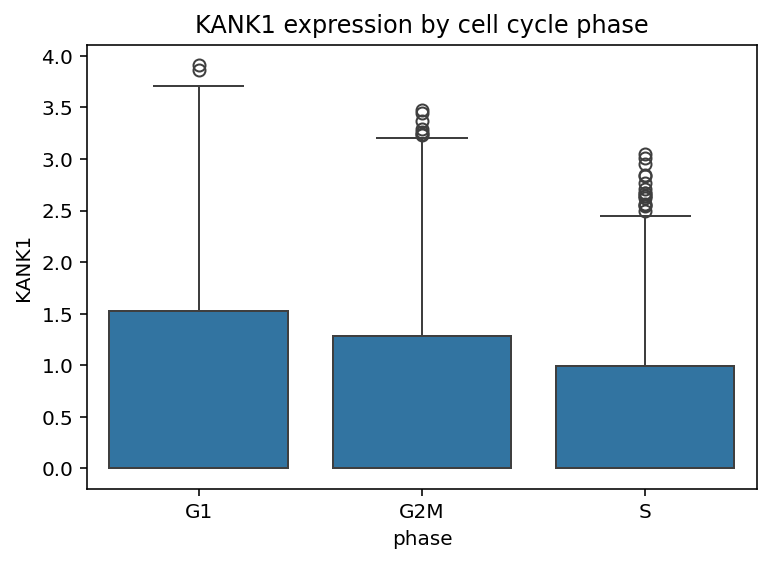

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

df = adata.to_df()
df["phase"] = adata.obs["phase"]
sns.boxplot(data=df, x="phase", y="KANK1")
plt.title("KANK1 expression by cell cycle phase")
plt.show()